In [18]:
import scipy as sp
import scipy.io.wavfile as wavfile
import os
from gmmhmm import *
from MFCC import *
from speechrecognition import *
import numpy as np
from numpy.linalg import *
import re
import random
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Problem 1

Write a function which accepts a GMMHMM as well as
an integer n_sim, and which simulates the GMMHMM process, generating n_sim different
observations. Use the example GMMHMM to sample 900 times. Use PCA from SkLearn to plot your generated observations in 2D space. Color observations by state.

In [2]:
# code copied from reading #############################################
A = np.array([[.65, .35], [.15, .85]])
# state transition matrix
pi = np.array([.8, .2])
# initial state distribution
weights = np.array([[.7, .2, .1], [.1, .5, .4]])
means1 = np.array([[0., 17., -4.], [5., -12., -8.], [-16., 22., 2.]])
means2 = np.array([[-5., 3., 23.], [-12., -2., 14.], [15., -32., 0.]])
means = np.array([means1, means2])
covars1 = np.array([5*np.eye(3), 7*np.eye(3), np.eye(3)])
covars2 = np.array([10*np.eye(3), 3*np.eye(3), 4*np.eye(3)])
covars = np.array([covars1, covars2])
gmmhmm = [A, weights, means, covars, pi]

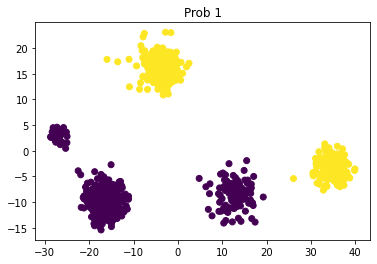

In [3]:
# simulate the GMMHMM 900 times ########################################
states, obs = sample_gmmhmm(gmmhmm, 900)

# plot results using sklearn ###########################################
my_PCA = PCA(n_components=2)
results = my_PCA.fit_transform(obs)
plt.scatter(results[:,0], results[:,1], c=states)
plt.title('Prob 1')
plt.show()

## Problem 2

Samples.zip contains 30 recordings for each of the words/phrases mathematics, biology, political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. 
Load the recordings into Python using scipy.io.wavfile.read

Extract the MFCCs from each sample using code from the file MFCC.py.
Store the MFCCs for each word in a separate list. You should have five lists, each containing
30 MFCC arrays, corresponding to each of the five words under consideration.

/home/celo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  # Remove the CWD from sys.path while we load stuff.
/home/celo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if sys.path[0] == '':
/home/celo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  
/home/celo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: WavFileWarning: Chunk (non-data) not understood, skipping it.
  app.launch_new_instance()
/home/celo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.


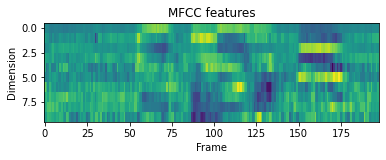

In [16]:
# read in and extract the wav files ####################################
cwd = os.getcwd()
math_names = [f'Mathematics ({i}).wav' for i in range(1, 31)]
bio_names = [f'Biology ({i}).wav' for i in range(1, 31)]
pol_names = [f'PoliticalScience ({i}).wav' for i in range(1, 31)]
psy_names = [f'Psychology ({i}).wav' for i in range(1, 31)]
stat_names = [f'Statistics ({i}).wav' for i in range(1, 31)]

math_MFCCs = [extract((wavfile.read(cwd+ '/Samples/' + math_names[i]))[1])\
              for i in range(len(math_names))]
bio_MFCCs = [extract((wavfile.read(cwd+ '/Samples/' + math_names[i]))[1])\
              for i in range(len(bio_names))]
pol_MFCCs = [extract((wavfile.read(cwd+ '/Samples/' + math_names[i]))[1])\
              for i in range(len(pol_names))]
psy_MFCCs = [extract((wavfile.read(cwd+ '/Samples/' + math_names[i]))[1])\
              for i in range(len(psy_names))]
stat_MFCCs = [extract((wavfile.read(cwd+ '/Samples/' + math_names[i]))[1])\
              for i in range(len(stat_names))]

## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.
Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood). This process may take several minutes. Since you will not want to run this
more than once, you will want to save the best model for each word to disk using the pickle
module so that you can use it later.

In [30]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += sp.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + sp.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

In [54]:
# split wavfile datasets and prep shared values ########################
math_train, math_test = train_test_split(math_MFCCs, train_size=20)
bio_train, bio_test = train_test_split(bio_MFCCs, train_size=20)
pol_train, pol_test = train_test_split(pol_MFCCs, train_size=20)
psy_train, psy_test = train_test_split(psy_MFCCs, train_size=20)
stat_train, stat_test = train_test_split(stat_MFCCs, train_size=20)

math_models = []
bio_models = []
pol_models = []
psy_models = []
stat_models = []

In [1]:
# create math models ###################################################
for i in range(10):
    startprob, transmat = initialize(5)
    model = GMMHMM(n_components=5, n_mix=3, transmat=transmat,\
                   startprob=startprob, cvtype='diag')
    model.covars_prior = 0.01
    model.fit(math_train, init_params='mc', var=0.1)
    math_models.append(model)
with open('math.pickle', 'wb') as file:
    pickle.dump(math_models, file)

In [35]:
# create bio models ####################################################
for i in range(10):
    startprob, transmat = initialize(5)
    model = GMMHMM(n_components=5, n_mix=3, transmat=transmat,\
                   startprob=startprob, cvtype='diag')
    model.covars_prior = 0.01
    model.fit(bio_train, init_params='mc', var=0.1)
    bio_models.append(model)
with open('bio.pickle', 'wb') as file:
    pickle.dump(bio_models, file)

In [36]:
# create pol models ####################################################
for i in range(10):
    startprob, transmat = initialize(5)
    model = GMMHMM(n_components=5, n_mix=3, transmat=transmat,\
                   startprob=startprob, cvtype='diag')
    model.covars_prior = 0.01
    model.fit(pol_train, init_params='mc', var=0.1)
    pol_models.append(model)
with open('pol.pickle', 'wb') as file:
    pickle.dump(pol_models, file)

In [37]:
# create psy models ####################################################
for i in range(10):
    startprob, transmat = initialize(5)
    model = GMMHMM(n_components=5, n_mix=3, transmat=transmat,\
                   startprob=startprob, cvtype='diag')
    model.covars_prior = 0.01
    model.fit(psy_train, init_params='mc', var=0.1)
    psy_models.append(model)
with open('psy.pickle', 'wb') as file:
    pickle.dump(psy_models, file)

In [38]:
# create stat models ###################################################
for i in range(10):
    startprob, transmat = initialize(5)
    model = GMMHMM(n_components=5, n_mix=3, transmat=transmat,\
                   startprob=startprob, cvtype='diag')
    model.covars_prior = 0.01
    model.fit(stat_train, init_params='mc', var=0.1)
    stat_models.append(model)
with open('stat.pickle', 'wb') as file:
    pickle.dump(stat_models, file)

## Problem 4

Classify the 10 test samples for each word. Make a dictionary containing the accuracy
of the classification of your five testing sets where the words/phrases are the keys,
and the values are the percent accuracy.

Write a few sentences answering the following questions:
How does your system perform?
Which words are the hardest to correctly classify?

In [64]:
# load models from pickles #############################################
with open('math.pickle', 'rb') as infile:
    math_models = pickle.load(infile)
with open('bio.pickle', 'rb') as infile:
    bio_models = pickle.load(infile)
with open('pol.pickle', 'rb') as infile:
    pol_models = pickle.load(infile)
with open('psy.pickle', 'rb') as infile:
    psy_models = pickle.load(infile)
with open('stat.pickle', 'rb') as infile:
    stat_models = pickle.load(infile)
    
# choose best model ####################################################
math_logs = [math_models[i].logprob for i in range(10)]
bio_logs = [bio_models[i].logprob for i in range(10)]
pol_logs = [pol_models[i].logprob for i in range(10)]
psy_logs = [psy_models[i].logprob for i in range(10)]
stat_logs = [stat_models[i].logprob for i in range(10)]

math_model = math_models[np.argmax(math_logs)]
bio_model = bio_models[np.argmax(bio_logs)]
pol_model = pol_models[np.argmax(pol_logs)]
psy_model = psy_models[np.argmax(psy_logs)]
stat_model = stat_models[np.argmax(stat_logs)]
models = [math_model, bio_model, pol_model, psy_model, stat_model]

In [66]:
# calculate best model & score #########################################
results = {}
results['mathematics'] = 0
results['biology'] = 0
results['polisci'] = 0
results['psychology'] = 0
results['statistics'] = 0

for i in range(10):
    top = np.argmax([model.score(math_test[i]) for model in models])
    if top == 0:
        results['mathematics'] += .1
    top = np.argmax([model.score(bio_test[i]) for model in models])
    if top == 1:
        results['biology'] += .1
    top = np.argmax([model.score(pol_test[i]) for model in models])
    if top == 2:
        results['polisci'] += .1
    top = np.argmax([model.score(psy_test[i]) for model in models])
    if top == 3:
        results['psychology'] += .1
    top = np.argmax([model.score(stat_test[i]) for model in models])
    if top == 4:
        results['statistics'] += .1

print(results)

{'mathematics': 0, 'biology': 0.1, 'polisci': 0.1, 'psychology': 0.2, 'statistics': 0.1}
